In [1]:
%pip install kaggle kagglehub pyarrow fastparquet scikit-learn rdkit captum git+https://github.com/samoturk/mol2vec;

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-rwkwjb_h
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-rwkwjb_h
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
%env KAGGLE_USERNAME=ankushhv
%env KAGGLE_KEY=17e732fa72ff39111cf907184aa2a00f

env: KAGGLE_USERNAME=ankushhv
env: KAGGLE_KEY=17e732fa72ff39111cf907184aa2a00f


In [3]:
!kaggle competitions download -c open-problems-single-cell-perturbations
!unzip -q open-problems-single-cell-perturbations.zip -d opxmoe_data

In [4]:
import torch
import numpy as np
import pandas as pd
import os

In [5]:
import kagglehub
kagglehub.login()
model_path = kagglehub.model_download("ankushhv/mol2vec/pyTorch/default")
data_path = "opxmoe_data"

print("Path to model files:", model_path)

Path to model files: /root/.cache/kagglehub/models/ankushhv/mol2vec/pyTorch/default/1


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda


In [7]:
df = pd.read_parquet(f"{data_path}/de_train.parquet")
df.tail()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112
613,T regulatory cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.757116,0.085910,-0.730025,-1.367801,-0.695944,...,0.232343,-2.247816,-0.346036,-0.919567,-1.131372,-0.120252,-0.064537,-0.603280,-0.098041,-0.750681


In [8]:
from abc import ABC, abstractmethod
class BaseEmbedding(ABC):
    @abstractmethod
    def preprocess(self, df):
        pass

    @abstractmethod
    def get_embedding(self, df):
        pass

    @property
    @abstractmethod
    def embedding_size(self):
        pass


In [9]:
!pip install scikit-learn

In [10]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, MolSentence
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, QED
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcNumRotatableBonds, CalcNumHBA, CalcNumHBD, CalcFractionCSP3
from rdkit.Chem import BRICS, Recap
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class OneHotEmbedding(BaseEmbedding):
    def __init__(self, columns):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse_output=False)
        self._embedding_size = None

    def preprocess(self, df):
        return df[self.columns]

    def get_embedding(self, df, fit=True):
        if fit:
            encoded_features = self.encoder.fit_transform(df[self.columns])
        else:
            encoded_features = self.encoder.transform(df[self.columns])
        self._embedding_size = encoded_features.shape[1]
        return pd.DataFrame(encoded_features, columns=self.encoder.get_feature_names_out(self.columns))

    @property
    def embedding_size(self):
        return self._embedding_size
    
class SMILESEmbedding(BaseEmbedding):
    def __init__(self):
        self.scaler = StandardScaler()

    def preprocess(self, df):
        return df

    def get_embedding(self, df, fit=True):
        smiles_info_list = df['SMILES'].apply(self.extract_smiles_info)
        smiles_info_df = pd.DataFrame(smiles_info_list.tolist())
        if fit:
            smiles_info_df = self.scaler.fit_transform(smiles_info_df)
        else:
            smiles_info_df = self.scaler.transform(smiles_info_df)
        return pd.DataFrame(smiles_info_df, columns=[
            'Molecular Weight', 'LogP', 'TPSA', 'Number of Atoms', 'Number of Bonds',
            'Number of Rotatable Bonds', 'Number of Hydrogen Bond Acceptors', 'Number of Hydrogen Bond Donors',
            'Number of Rings', 'Number of Aromatic Rings', 'Number of Stereocenters',
            'Fraction of sp3 Carbons', 'Balaban J Index', 'Bertz CT', 'QED Score'
        ])

    @staticmethod
    def extract_smiles_info(smiles):
        if smiles is None or smiles == '':
            return None
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        info = {
            'Molecular Weight': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'TPSA': CalcTPSA(mol),
            'Number of Atoms': mol.GetNumAtoms(),
            'Number of Bonds': mol.GetNumBonds(),
            'Number of Rotatable Bonds': CalcNumRotatableBonds(mol),
            'Number of Hydrogen Bond Acceptors': CalcNumHBA(mol),
            'Number of Hydrogen Bond Donors': CalcNumHBD(mol),
            'Number of Rings': Descriptors.RingCount(mol),
            'Number of Aromatic Rings': rdMolDescriptors.CalcNumAromaticRings(mol),
            'Number of Stereocenters': len(Chem.FindMolChiralCenters(mol, includeUnassigned=True)),
            'Fraction of sp3 Carbons': CalcFractionCSP3(mol),
            'Balaban J Index': Descriptors.BalabanJ(mol),
            'Bertz CT': Descriptors.BertzCT(mol),
            'QED Score': QED.qed(mol)
        }
        return info

    @property
    def embedding_size(self):
        return 15  

class Mol2VecEmbedding(BaseEmbedding):
    def __init__(self, model_path):
        self.model = word2vec.Word2Vec.load(model_path)
        self.keys = set(self.model.wv.key_to_index.keys())

    def preprocess(self, df):
        df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
        df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
        return df

    def get_embedding(self, df, fit=True):
        df['vector'] = df['sentence'].apply(lambda sentence: self.sentence_to_vector(sentence))
        vector_dim = len(self.model.wv.get_vector(next(iter(self.keys))))
        vector_columns = [f'vector_{i}' for i in range(vector_dim)]
        return pd.DataFrame(df['vector'].tolist(), columns=vector_columns)

    def sentence_to_vector(self, sentence, unseen=False, unseen_vec=np.zeros(300)):
        if unseen:
            vec = sum([self.model.wv.get_vector(word) if word in self.keys else unseen_vec for word in sentence])
        else:
            vec = sum([self.model.wv.get_vector(word) for word in sentence if word in self.keys])
        return vec

    @property
    def embedding_size(self):
        return len(self.model.wv.get_vector(next(iter(self.keys))))
    

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded      
    
class MorganFingerPrintEmbedding(BaseEmbedding):
    def __init__(self, hidden_size=128):
        self.hidden_size = hidden_size
        self.autoencoder = None  # This will store the trained autoencoder

    def preprocess(self, df):
        return df

    def get_embedding(self, df, fit=True):
        # Extract Morgan fingerprints
        morgan_fp_list = df['SMILES'].apply(self.extract_morgan_fingerprint)
        morgan_fp_array = np.stack(morgan_fp_list)

        input_size = morgan_fp_array.shape[1]

        if fit:
            # Train autoencoder
            self.autoencoder = self.train_autoencoder(morgan_fp_array, input_size, self.hidden_size)
        
        # Get compressed fingerprints
        with torch.no_grad():
            compressed_fp = self.autoencoder.encoder(torch.tensor(morgan_fp_array, dtype=torch.float32)).numpy()

        compressed_fp_df = pd.DataFrame(compressed_fp, columns=[f'CompressedFP_{i}' for i in range(self.hidden_size)])
        return compressed_fp_df

    def extract_morgan_fingerprint(self, smiles, radius=2, nBits=2048):
        if smiles is None or smiles == '':
            return None
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        morgan_gen = AllChem.GetMorganGenerator(radius=radius, fpSize=nBits)
        fp = morgan_gen.GetFingerprint(mol)
        
        fp_array = np.zeros((nBits,))
        DataStructs.ConvertToNumpyArray(fp, fp_array)
        
        return fp_array

    def train_autoencoder(self, data, input_size, hidden_size, num_epochs=70, batch_size=32, learning_rate=0.001):
        autoencoder = Autoencoder(input_size=input_size, hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

        dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            for batch in dataloader:
                inputs = batch[0]
                _, reconstructed = autoencoder(inputs)

                loss = criterion(reconstructed, inputs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

        return autoencoder

    @property
    def embedding_size(self):
        return self.hidden_size

In [11]:
class Preprocessor:
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.embedding_indices = {}

    def preprocess(self, df, fit=True):
        processed_dfs = []
        current_index = 0

        for embedding in self.embeddings:
            preprocessed_df = embedding.preprocess(df)
            embedded_df = embedding.get_embedding(preprocessed_df, fit=fit)
            processed_dfs.append(embedded_df)

            embedding_name = embedding.__class__.__name__
            self.embedding_indices[embedding_name] = (current_index, current_index + embedding.embedding_size)
            current_index += embedding.embedding_size

        return pd.concat(processed_dfs, axis=1)

    def generate_expert_config(self, expert_specs):
        """
        expert_specs: A dictionary where keys are expert names and values are lists of embedding names to combine.
        
        Example format:
        {
            "lstm_expert_1": ["OneHotEmbedding", "MorganFingerPrintEmbedding"],
            "lstm_expert_2": ["OneHotEmbedding", "SMILESEmbedding"],
            "lstm_expert_3": ["SMILESEmbedding", "Mol2VecEmbedding"],
        }
        """
        expert_config = {}
        
        for expert, embedding_names in expert_specs.items():
            indices = []
            for embedding_name in embedding_names:
                start, end = self.embedding_indices[embedding_name]
                indices.extend(range(start, end))
            expert_config[expert] = indices
        
        return expert_config

In [12]:
onehot_embedding = OneHotEmbedding(columns=['cell_type', 'sm_name'])
smiles_embedding = SMILESEmbedding()
mol2vec_embedding = Mol2VecEmbedding(f"{model_path}/model_300dim.pkl")
morgan_embedding = MorganFingerPrintEmbedding(hidden_size=128)

In [13]:
preprocessor_train = Preprocessor([onehot_embedding, smiles_embedding, mol2vec_embedding,morgan_embedding])

In [14]:
target_cols = ['cell_type','sm_name','sm_lincs_id','SMILES','control']
targets = df.drop(columns=target_cols)
processed_df_train = preprocessor_train.preprocess(df, fit=True)

[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerator
[07:50:41] DEPRECATION WARNING: please use MorganGenerat

Epoch [10/70], Loss: 0.0201
Epoch [20/70], Loss: 0.0135
Epoch [30/70], Loss: 0.0083
Epoch [40/70], Loss: 0.0038
Epoch [50/70], Loss: 0.0027
Epoch [60/70], Loss: 0.0033
Epoch [70/70], Loss: 0.0046


In [15]:
preprocessor_train.embedding_indices

{'OneHotEmbedding': (0, 152),
 'SMILESEmbedding': (152, 167),
 'Mol2VecEmbedding': (167, 467),
 'MorganFingerPrintEmbedding': (467, 595)}

In [16]:
# processed_df_train.shape
print("Processed Training DataFrame shape:", processed_df_train.shape)
print("Training Embedding indices:", preprocessor_train.embedding_indices)

Processed Training DataFrame shape: (614, 595)
Training Embedding indices: {'OneHotEmbedding': (0, 152), 'SMILESEmbedding': (152, 167), 'Mol2VecEmbedding': (167, 467), 'MorganFingerPrintEmbedding': (467, 595)}


In [17]:
feature_names = list(processed_df_train.columns)
print(len(feature_names))
train_array = processed_df_train.to_numpy()

595


In [18]:
import torch
X = torch.tensor(train_array,dtype=torch.float32)
y = torch.tensor(targets.values, dtype=torch.float32)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: torch.Size([614, 595]), y shape: torch.Size([614, 18211])


In [19]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = X.to(device)
y = y.to(device)

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [20]:
import random
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('-----Seed Set!-----')

-----Seed Set!-----


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

class LSTMExpert(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, num_layers=2, dropout=0.3):
        super(LSTMExpert, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=4)
        
        # Fully connected layers with residual connections
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, output_size)
        
        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_size * 2)
        self.layer_norm2 = nn.LayerNorm(hidden_size * 2)
        self.layer_norm3 = nn.LayerNorm(hidden_size * 2)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Ensure input is 3D
        if x.dim() == 2:
            x = x.unsqueeze(1)
        
        # LSTM layers
        lstm_out, _ = self.lstm(x)
        
        # Apply attention
        lstm_out = lstm_out.permute(1, 0, 2)  # Change to (seq_len, batch, feature)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_out = attn_out.permute(1, 0, 2)  # Change back to (batch, seq_len, feature)
        
        # Take the last output or apply global average pooling
        if attn_out.size(1) == 1:
            out = attn_out.squeeze(1)
        else:
            out = F.adaptive_avg_pool1d(attn_out.transpose(1, 2), 1).squeeze(-1)
        
        # Fully connected layers with residual connections
        out = self.layer_norm1(out)
        residual = out
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.layer_norm2(out)
        out = out + residual
        
        residual = out
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.layer_norm3(out)
        out = out + residual
        
        out = self.fc3(out)
        
        return out


class NNExpert(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.5):
        super(NNExpert, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        output = self.network(x)
        return output

class GatingNetwork(nn.Module):
    def __init__(self, input_size, num_experts, hidden_size=512):
        super(GatingNetwork, self).__init__()
        self.input_size = input_size
        self.num_experts = num_experts
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=4)
        
        self.output_layer = nn.Linear(hidden_size, num_experts)
        
    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.unsqueeze(0)  # Add sequence dimension for attention
        attn_output, _ = self.attention(features, features, features)
        attn_output = attn_output.squeeze(0)
        
        logits = self.output_layer(attn_output)
        return F.softmax(logits, dim=-1)
    
# class GatingNetwork(nn.Module):
#     def __init__(self, input_size, num_experts, initial_temperature=1.0):
#         super(GatingNetwork, self).__init__()

#         # First and second blocks using nn.Sequential
#         self.fc1 = nn.Sequential(
#             nn.Linear(input_size, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.3)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(256, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.3)
#         )

#         # Attention mechanism
#         self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)

#         # Final layer for outputting expert weights (logits)
#         self.fc3 = nn.Linear(256, num_experts)

#         # Temperature parameter
#         self.temperature = nn.Parameter(torch.ones(1) * initial_temperature)

#     def forward(self, x):
#         identity = self.fc1[0](x)  # Pass through the first Linear layer

#         # Pass through the first and second blocks
#         out = self.fc1(x)
#         out = self.fc2(out)

#         # Residual connection
#         out = out + identity

#         # Attention mechanism: Add sequence dimension
#         out = out.unsqueeze(0)
#         attn_output, _ = self.attention(out, out, out)
#         attn_output = attn_output.squeeze(0)

#         # Pass through the final linear layer to get logits
#         logits = self.fc3(attn_output)

#         # Apply temperature scaling before softmax
#         return F.softmax(logits / self.temperature, dim=-1)
    
# class GatingNetwork(nn.Module):
#     def __init__(self, input_size, num_experts):
#         super(GatingNetwork, self).__init__()
#         self.lstm = nn.LSTM(input_size, 128, 1, batch_first=True)
#         self.linear = nn.Sequential(
#             nn.Linear(128, 256),  # Hidden state output from LSTM to fully connected
#             nn.ReLU(),            # ReLU activation
#             nn.Dropout(0.3),      # Dropout for regularization
#             nn.Linear(256, num_experts),  # Second hidden layer
#             nn.ReLU(),
#             nn.Dropout(0.3)
#         )
#         self.softmax = nn.Softmax(dim=-1)

#     def forward(self, x):
#         # Check if input is a sequence or not
#         if x.dim() == 2:
#             # If input is (batch_size, input_size), add a sequence dimension
#             x = x.unsqueeze(1)
        
#         # Now x shape should be (batch_size, sequence_length, input_size)
#         lstm_out, _ = self.lstm(x)
        
#         # Use the last output of the LSTM
#         last_output = lstm_out[:, -1, :]
#         x = self.linear(last_output)
#         x = self.softmax(x)
#         return x

class MixtureOfExperts(nn.Module):
    def __init__(self, expert_configs, output_size=18211):
        super(MixtureOfExperts, self).__init__()
        self.experts = nn.ModuleDict()
        self.feature_indices = {}
        total_features = set()

        for expert_name, feature_indices in expert_configs.items():
            input_size = len(feature_indices)
            if expert_name.startswith('lstm'):
                self.experts[expert_name] = LSTMExpert(input_size, output_size)
            elif expert_name.startswith('nn'):
                self.experts[expert_name] = NNExpert(input_size, output_size)
            else:
                raise ValueError(f"Unknown expert type for {expert_name}")
            
            self.feature_indices[expert_name] = feature_indices
            total_features.update(feature_indices)

        # Set up the gating network with the total number of features across all experts
        self.gating_network = GatingNetwork(len(total_features), len(self.experts))
        self.total_features = sorted(list(total_features))  # Keep indices sorted
        self.last_gating_weights = None

    def forward(self, data, return_gating_logits=False):
        # Prepare input for gating network
        gating_input = data[:, self.total_features]
        gating_logits = self.gating_network(gating_input)
        gating_weights = F.softmax(gating_logits, dim=-1)
        self.last_gating_weights = gating_weights.detach()

        expert_outputs = []
        for expert_name, expert in self.experts.items():
            expert_input = data[:, self.feature_indices[expert_name]]
            expert_output = expert(expert_input)
            expert_outputs.append(expert_output)

        expert_outputs = torch.stack(expert_outputs, dim=1)
        combined_output = torch.sum(expert_outputs * gating_weights.unsqueeze(-1), dim=1)

        if return_gating_logits:
            return combined_output, gating_logits
        else:
            return combined_output

# Utility functions remain unchanged
def RMSE_rowwise_loss(y_pred, y_true):
    return torch.sqrt(torch.mean((y_pred - y_true)**2, dim=1)).mean()

class EarlyStopping:
    def __init__(self, patience=20, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
            return False
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0
        return False

In [22]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs=200, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    early_stopping = EarlyStopping(patience=10)
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        train_loss = 0
        for batch, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(X)
            loss = RMSE_rowwise_loss(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                output = model(X)
                val_loss += RMSE_rowwise_loss(output, y).item()

        val_losses.append(val_loss / len(val_loader))
        
        if val_loss < early_stopping.val_loss_min:
            best_model_state = model.state_dict()
        
        if early_stopping(val_loss):
            print("Early stopping triggered")
            model.load_state_dict(best_model_state)  # Load the best model
            break

        if epoch % 10 == 0 or epoch == epochs - 1:  # Also print on the last epoch
            tqdm.write(f"Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        scheduler.step(val_loss)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

    return train_losses, val_losses

In [23]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.utils import clip_grad_norm_

def noisy_top_k_gating(logits, noise_epsilon=0.1, training=True):
    if training:
        noise = torch.randn_like(logits) * noise_epsilon
        noisy_logits = logits + noise
    else:
        noisy_logits = logits
    return F.softmax(noisy_logits, dim=-1)

def custom_loss(y_pred, y_true, gating_logits, diversity_weight=0.1, noise_epsilon=0.1, training=True):
    # Main loss (RMSE)
    main_loss = RMSE_rowwise_loss(y_pred, y_true)
    
    # Apply noisy top-k gating
    noisy_gating_weights = noisy_top_k_gating(gating_logits, noise_epsilon, training)
    
    # Diversity loss (encourage using different experts)
    avg_expert_usage = noisy_gating_weights.mean(dim=0)
    diversity_loss = -torch.sum(avg_expert_usage * torch.log(avg_expert_usage + 1e-10))
    
    # Combine losses
    total_loss = main_loss - diversity_weight * diversity_loss
    
    return total_loss, noisy_gating_weights

def pretrain_expert(expert, train_loader, val_loader, feature_indices, device, epochs=100, lr=1e-4):
    expert.to(device)
    optimizer = optim.Adam(expert.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    early_stopping = EarlyStopping(patience=10)
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs), desc=f"Pretraining {type(expert).__name__}"):
        expert.train()
        train_loss = 0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X[:, feature_indices].to(device), y.to(device)
            optimizer.zero_grad()
            output = expert(X)
            loss = RMSE_rowwise_loss(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        expert.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X[:, feature_indices].to(device), y.to(device)
                output = expert(X)
                val_loss += RMSE_rowwise_loss(output, y).item()
        
        val_losses.append(val_loss / len(val_loader))
        
        if val_loss < early_stopping.val_loss_min:
            best_model_state = expert.state_dict()
        
        if early_stopping(val_loss):
            print("Early stopping triggered")
            expert.load_state_dict(best_model_state)  # Load the best model
            break
        
        if epoch % 10 == 0 or epoch == epochs - 1:
            tqdm.write(f"Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        
        scheduler.step(val_losses[-1])
    
    return train_losses, val_losses

def train_gating_network(moe, train_loader, val_loader, device, epochs=50, lr=1e-3, noise_epsilon=1e-2):
    # Freeze expert parameters
    for expert in moe.experts.values():
        for param in expert.parameters():
            param.requires_grad = False
    
    # Ensure gating network parameters are unfrozen
    for param in moe.gating_network.parameters():
        param.requires_grad = True
    
    # Move model to device
    moe.to(device)
    
    optimizer = optim.Adam(moe.gating_network.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    early_stopping = EarlyStopping(patience=10)
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs), desc="Training Gating Network"):
        moe.train()
        train_loss = 0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            output, gating_logits = moe(X, return_gating_logits=True)
            
            # Custom loss with noisy top-k gating
            loss, noisy_gating_weights = custom_loss(output, y, gating_logits, 
                                                     noise_epsilon=noise_epsilon, 
                                                     training=True)
            
            loss.backward()
            clip_grad_norm_(moe.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        moe.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                output, gating_logits = moe(X, return_gating_logits=True)
                loss, _ = custom_loss(output, y, gating_logits, 
                                      noise_epsilon=noise_epsilon, 
                                      training=False)
                val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        
        if val_loss < early_stopping.val_loss_min:
            best_model_state = moe.gating_network.state_dict()
        
        if early_stopping(val_loss):
            print("Early stopping triggered")
            moe.gating_network.load_state_dict(best_model_state)  # Load the best model
            break
        
        if epoch % 5 == 0 or epoch == epochs - 1:
            tqdm.write(f"Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        
        if epoch % 10 == 0:
            plot_expert_utilization(moe.last_gating_weights)
        
        scheduler.step(val_losses[-1])
    
    # Unfreeze expert parameters after training
    for expert in moe.experts.values():
        for param in expert.parameters():
            param.requires_grad = True
    
    return train_losses, val_losses

def plot_training_curves(train_losses, val_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()  
    
def plot_expert_utilization(gating_weights):
    avg_expert_usage = gating_weights.mean(dim=0).cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(avg_expert_usage)), avg_expert_usage)
    plt.title("Average Expert Utilization")
    plt.xlabel("Expert")
    plt.ylabel("Average Usage")
    plt.show()

In [24]:
from captum.attr import IntegratedGradients, Saliency, DeepLift, ShapleyValueSampling
def cross_validate_model(model_class, config, X, y, n_splits=5, epochs=200, lr=0.001):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_losses_cv = []
    val_losses_cv = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f'Fold {fold+1}/{n_splits}')

        # Create model instance for each fold
        model = model_class(config).to(device)
        model.float()

        # Create Datasets for the fold
        train_dataset = Subset(TensorDataset(X, y), train_idx)
        val_dataset = Subset(TensorDataset(X, y), val_idx)

        # Create DataLoaders for the fold
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)

        # Train the model for the current fold
        train_losses, val_losses = train_model(model, train_loader, val_loader, epochs, lr)
        
        # Store model and losses for later analysis
        models.append(model)
        train_losses_cv.append(train_losses)
        val_losses_cv.append(val_losses)

    # Ensure all loss lists have the same length by padding with np.nan
    max_epochs = min(len(losses) for losses in train_losses_cv)  # Use min if you want to truncate to shortest
    train_losses_cv = [losses[:max_epochs] for losses in train_losses_cv]  # Truncate to minimum length
    val_losses_cv = [losses[:max_epochs] for losses in val_losses_cv]

    # Convert to numpy arrays for averaging
    avg_train_loss = np.mean(np.array(train_losses_cv), axis=0)
    avg_val_loss = np.mean(np.array(val_losses_cv), axis=0)
    
    # Plotting average cross-validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_loss, label='Avg Train Loss')
    plt.plot(avg_val_loss, label='Avg Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{n_splits}-Fold Cross-Validation Losses')
    plt.show()

    return models, train_losses_cv, val_losses_cv

def compute_feature_importance(model, X, feature_names, k=10, baseline=None, target=0, method = 'integrated_gradients'):
    """
    Compute feature importance using various interpretability methods.

    Parameters:
    model (nn.Module): Trained PyTorch model.
    X (torch.Tensor): Input data.
    feature_names (list): List of feature names.
    k (int, optional): Number of top features to display. Default is 10.
    baseline (torch.Tensor, optional): Baseline input for interpretability methods. If None, a zero baseline is used.
    target (int, optional): Target output index for interpretability methods. Default is 0.
    methods (tuple, optional): Interpretability methods to use. Can include 'integrated_gradients', 'saliency', 'deeplift', and 'shapley'. Default is all methods.
    return_all (bool, optional): If True, returns the top k feature names, their importances, and the full feature importance array for each method. Default is False.

    Returns:
    If return_all is False (default):
        top_k_features (dict): Dictionary mapping method name to list of top k feature names.
    If return_all is True:
        top_k_features (dict), top_k_importances (dict), all_importances (dict)
    """
    # Ensure the model is on CPU
    # model.cpu()
    model.eval()  # Set model to evaluation mode
    
    # Move input to CPU if necessary
    # X = X.cpu()
    # Choose baseline: it should have the same shape as X (defaults to zero baseline)
    if baseline is None:
        baseline = torch.zeros_like(X)
    else:
        baseline = baseline.cpu()  # Ensure baseline is on CPU
    
    top_k_features = {}
    top_k_importances = {}
    all_importances = {}
    
    explainer = IntegratedGradients(model)
    attributions = explainer.attribute(X, baselines=baseline, target=target)
    
    if method == 'integrated_gradients':
        explainer = IntegratedGradients(model)
        attributions = explainer.attribute(X, baselines=baseline, target=target)
    elif method == 'saliency':
        explainer = Saliency(model)
        attributions = explainer.attribute(X, target=target)
    elif method == 'deeplift':
        explainer = DeepLift(model)
        attributions = explainer.attribute(X, baselines=baseline, target=target)
    elif method == 'shapley':
        explainer = ShapleyValueSampling(model)
        attributions = explainer.attribute(X, baselines=baseline, target=target, show_progress=True)
    else:
        raise ValueError(f"Unsupported method: {method}. Use 'integrated_gradients', 'saliency', 'deeplift', or 'shapley'.")
        
        # Convert attributions to numpy for further processing
    attributions_np = attributions.cpu().detach().numpy()
    # Average feature importance across all samples
    avg_importance = attributions_np.mean(axis=0)

    # Get the indices of the top k features
    top_k_indices = np.argsort(np.abs(avg_importance))[-k:][::-1]

    # Get the names and importances of the top k features
    top_k_features[method] = [feature_names[i] for i in top_k_indices]
    top_k_importances[method] = avg_importance[top_k_indices]
    all_importances[method] = avg_importance

    # Plot the attributions for top k features
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[top_k_indices], top_k_importances[method])
    plt.xlabel("Average Importance across samples")
    plt.ylabel("Top Features")
    plt.title(f"Top {k} Feature Importance ({method})")
    plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_expert_weights(model, data_loader, expert_names, num_samples=100):
    model.eval()
    all_weights = []
    all_labels = []
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            if i >= num_samples:
                break
            _ = model(inputs)  # Forward pass
            weights = model.last_gating_weights
            all_weights.append(weights.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_weights = np.concatenate(all_weights, axis=0)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(all_weights, cmap="YlOrRd", annot=False, fmt=".2f", cbar_kws={'label': 'Expert Weight'},
                xticklabels=expert_names)
    plt.title("Expert Weights for Different Input Instances")
    plt.xlabel("Expert")
    plt.ylabel("Input Instance")
    plt.tight_layout()
    plt.show()
    
    # Bar plot for average expert weights
    avg_weights = all_weights.mean(axis=0)
    plt.figure(figsize=(10, 6))
    plt.bar(expert_names, avg_weights)
    plt.title("Average Expert Weights")
    plt.xlabel("Expert")
    plt.ylabel("Average Weight")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

#     return all_weights, all_labels

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Dataset, Subset


def analyze_expert_clusters(model, data_loader, expert_names, num_samples=600, n_clusters=5):
    model.eval()
    all_inputs = []
    all_weights = []
    
    with torch.no_grad():
        for inputs, _ in data_loader:
            if len(all_inputs) * inputs.shape[0] >= num_samples:
                break
            _ = model(inputs)
            weights = model.last_gating_weights
            all_inputs.append(inputs.cpu().numpy())
            all_weights.append(weights.cpu().numpy())
    
    # Concatenate all batches of inputs and weights
    all_inputs = np.concatenate(all_inputs, axis=0)
    all_weights = np.concatenate(all_weights, axis=0)
    
    # Ensure we have exactly num_samples
    num_samples = min(num_samples, all_inputs.shape[0], all_weights.shape[0])
    all_inputs = all_inputs[:num_samples]
    all_weights = all_weights[:num_samples]
    
    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(all_inputs)
    centroids = kmeans.cluster_centers_
    
    # Combine input data and centroids for t-SNE
    combined_data = np.vstack([all_inputs, centroids])
    
    # Dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)
    
    # Split reduced data back into inputs and centroids
    reduced_inputs = reduced_data[:num_samples]
    reduced_centroids = reduced_data[num_samples:]
    
    # Ensure dominant_experts is also truncated to num_samples
    dominant_experts = np.argmax(all_weights, axis=1)
    dominant_experts = dominant_experts[:num_samples]
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Scatter plot
    scatter = plt.scatter(reduced_inputs[:, 0], reduced_inputs[:, 1], 
                          c=dominant_experts, cmap='viridis', 
                          alpha=0.6, s=50)
    
    # Add cluster centroids
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], 
                marker='x', s=200, linewidths=3, color='r', label='Cluster Centroids')
    
    plt.colorbar(scatter, label='Dominant Expert')
    plt.title('t-SNE Visualization of Input Data\nColored by Dominant Expert with Cluster Centroids')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Heatmap of expert dominance per cluster
    expert_cluster_counts = np.zeros((n_clusters, len(expert_names)))
    for cluster in range(n_clusters):
        cluster_mask = cluster_labels == cluster
        expert_cluster_counts[cluster] = np.sum(all_weights[cluster_mask], axis=0)
    
    expert_cluster_percentages = expert_cluster_counts / expert_cluster_counts.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(expert_cluster_percentages, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=expert_names)
    plt.title('Expert Dominance per Cluster')
    plt.xlabel('Expert')
    plt.ylabel('Cluster')
    plt.tight_layout()
    plt.show()
#     return reduced_inputs, dominant_experts, cluster_labels

Pretraining lstm_expert_1


Pretraining LSTMExpert:   1%|          | 2/300 [00:00<01:03,  4.71it/s]

Epoch 0: Train Loss: 1.5491, Val Loss: 1.4419


Pretraining LSTMExpert:   4%|▍         | 12/300 [00:01<00:38,  7.43it/s]

Epoch 10: Train Loss: 1.3944, Val Loss: 1.3714


Pretraining LSTMExpert:   7%|▋         | 22/300 [00:03<00:37,  7.34it/s]

Epoch 20: Train Loss: 1.2371, Val Loss: 1.3658


Pretraining LSTMExpert:  11%|█         | 32/300 [00:04<00:35,  7.56it/s]

Epoch 30: Train Loss: 1.2111, Val Loss: 1.3143


Pretraining LSTMExpert:  14%|█▍        | 42/300 [00:05<00:34,  7.57it/s]

Epoch 40: Train Loss: 1.1296, Val Loss: 1.2699


Pretraining LSTMExpert:  17%|█▋        | 52/300 [00:07<00:32,  7.57it/s]

Epoch 50: Train Loss: 1.1373, Val Loss: 1.2387


Pretraining LSTMExpert:  21%|██        | 62/300 [00:08<00:31,  7.57it/s]

Epoch 60: Train Loss: 1.1112, Val Loss: 1.2309


Pretraining LSTMExpert:  24%|██▍       | 72/300 [00:09<00:30,  7.57it/s]

Epoch 70: Train Loss: 1.0903, Val Loss: 1.2288


Pretraining LSTMExpert:  27%|██▋       | 80/300 [00:10<00:30,  7.31it/s]


Early stopping triggered


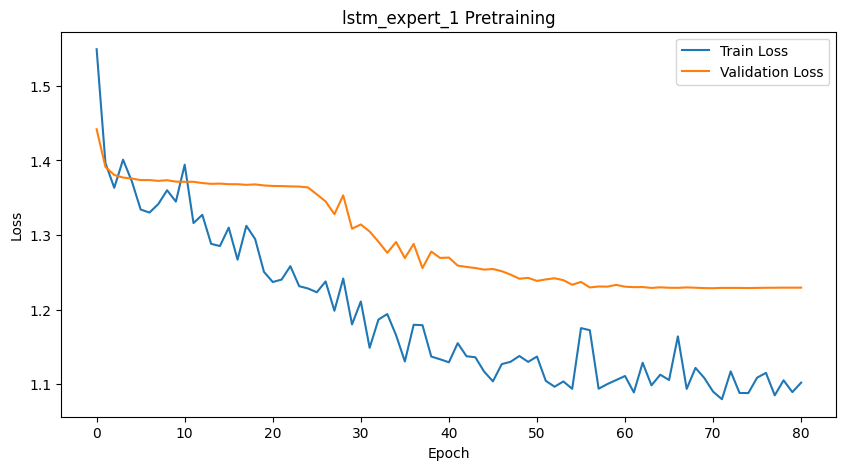

Pretraining lstm_expert_2


Pretraining LSTMExpert:   0%|          | 1/300 [00:00<00:41,  7.22it/s]

Epoch 0: Train Loss: 1.5675, Val Loss: 1.4297


Pretraining LSTMExpert:   4%|▍         | 12/300 [00:01<00:38,  7.49it/s]

Epoch 10: Train Loss: 1.3737, Val Loss: 1.3708


Pretraining LSTMExpert:   7%|▋         | 22/300 [00:02<00:37,  7.49it/s]

Epoch 20: Train Loss: 1.2934, Val Loss: 1.3657


Pretraining LSTMExpert:  11%|█         | 32/300 [00:04<00:35,  7.50it/s]

Epoch 30: Train Loss: 1.1871, Val Loss: 1.2794


Pretraining LSTMExpert:  14%|█▍        | 42/300 [00:05<00:34,  7.50it/s]

Epoch 40: Train Loss: 1.2010, Val Loss: 1.2524


Pretraining LSTMExpert:  17%|█▋        | 52/300 [00:06<00:33,  7.43it/s]

Epoch 50: Train Loss: 1.1801, Val Loss: 1.2501


Pretraining LSTMExpert:  21%|██        | 62/300 [00:08<00:31,  7.46it/s]

Epoch 60: Train Loss: 1.1651, Val Loss: 1.2519


Pretraining LSTMExpert:  21%|██        | 62/300 [00:08<00:32,  7.36it/s]


Early stopping triggered


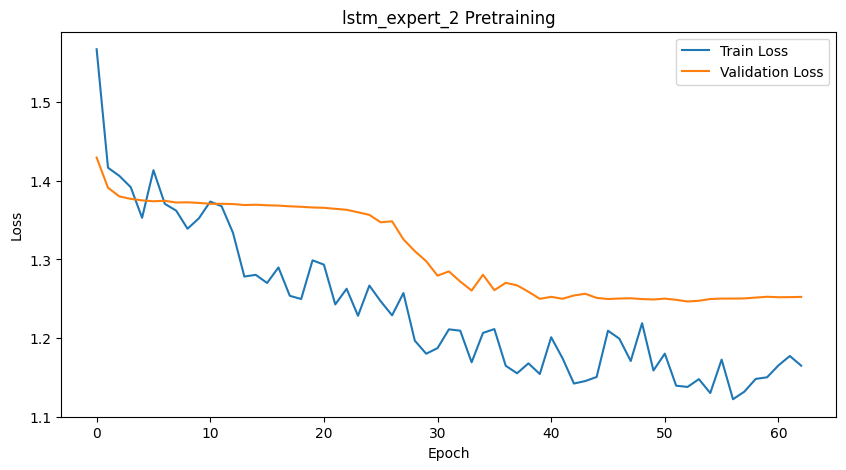

Pretraining lstm_expert_3


Pretraining LSTMExpert:   0%|          | 1/300 [00:00<00:41,  7.18it/s]

Epoch 0: Train Loss: 1.5203, Val Loss: 1.4407


Pretraining LSTMExpert:   4%|▍         | 12/300 [00:01<00:37,  7.58it/s]

Epoch 10: Train Loss: 1.3009, Val Loss: 1.3697


Pretraining LSTMExpert:   7%|▋         | 22/300 [00:02<00:38,  7.17it/s]

Epoch 20: Train Loss: 1.1980, Val Loss: 1.3209


Pretraining LSTMExpert:  11%|█         | 32/300 [00:04<00:37,  7.15it/s]

Epoch 30: Train Loss: 1.1482, Val Loss: 1.2648


Pretraining LSTMExpert:  14%|█▍        | 42/300 [00:05<00:35,  7.20it/s]

Epoch 40: Train Loss: 1.0893, Val Loss: 1.2474


Pretraining LSTMExpert:  17%|█▋        | 52/300 [00:07<00:34,  7.21it/s]

Epoch 50: Train Loss: 1.0858, Val Loss: 1.2458


Pretraining LSTMExpert:  18%|█▊        | 54/300 [00:07<00:34,  7.16it/s]


Early stopping triggered


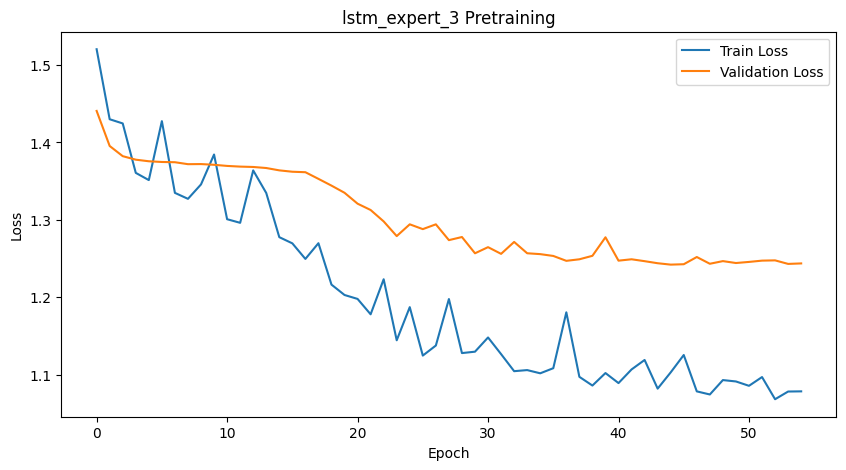

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training gating network


Training Gating Network:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0: Train Loss: 0.9695, Val Loss: 1.1174


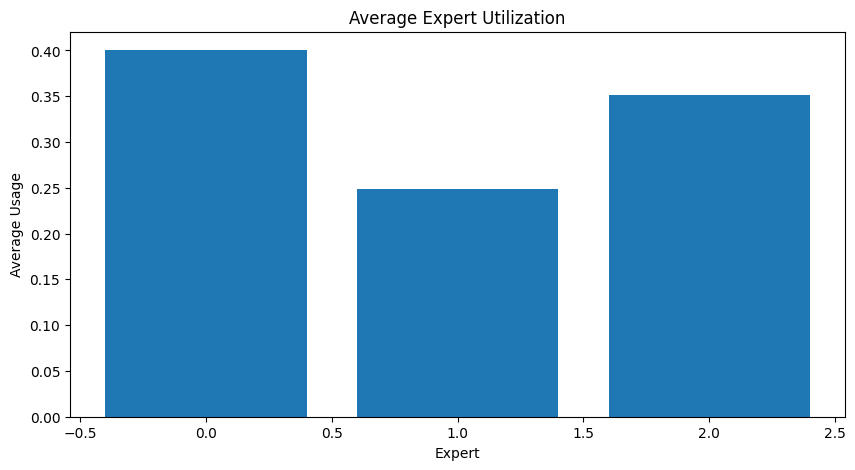

Training Gating Network:   2%|▏         | 7/300 [00:01<00:46,  6.30it/s]

Epoch 5: Train Loss: 0.9632, Val Loss: 1.1167


Training Gating Network:   3%|▎         | 10/300 [00:01<00:45,  6.44it/s]

Epoch 10: Train Loss: 0.9731, Val Loss: 1.1135


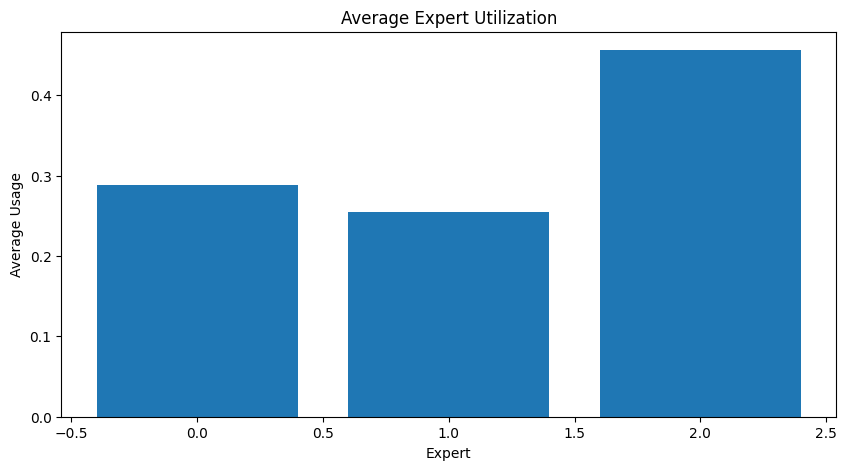

Training Gating Network:   6%|▌         | 17/300 [00:02<00:44,  6.42it/s]

Epoch 15: Train Loss: 0.9792, Val Loss: 1.1121


Training Gating Network:   7%|▋         | 20/300 [00:03<00:42,  6.56it/s]

Epoch 20: Train Loss: 0.9992, Val Loss: 1.1135


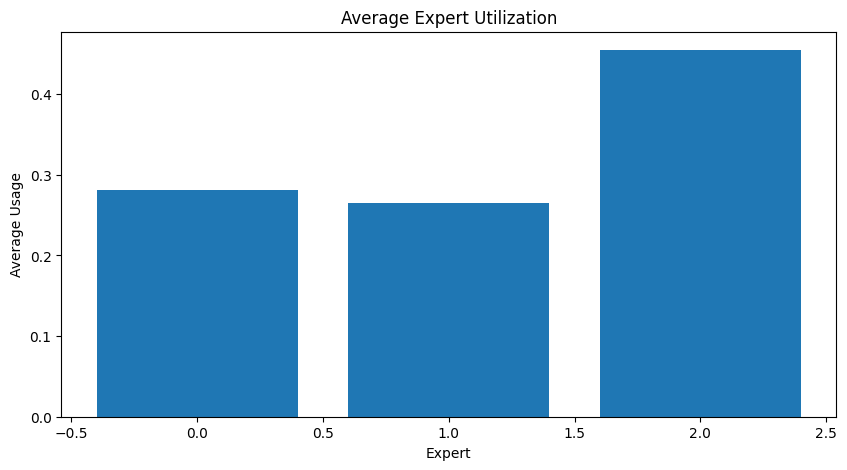

Training Gating Network:   9%|▉         | 27/300 [00:04<00:42,  6.40it/s]

Epoch 25: Train Loss: 0.9991, Val Loss: 1.1127


Training Gating Network:  10%|█         | 30/300 [00:05<00:41,  6.54it/s]

Epoch 30: Train Loss: 0.9879, Val Loss: 1.1123


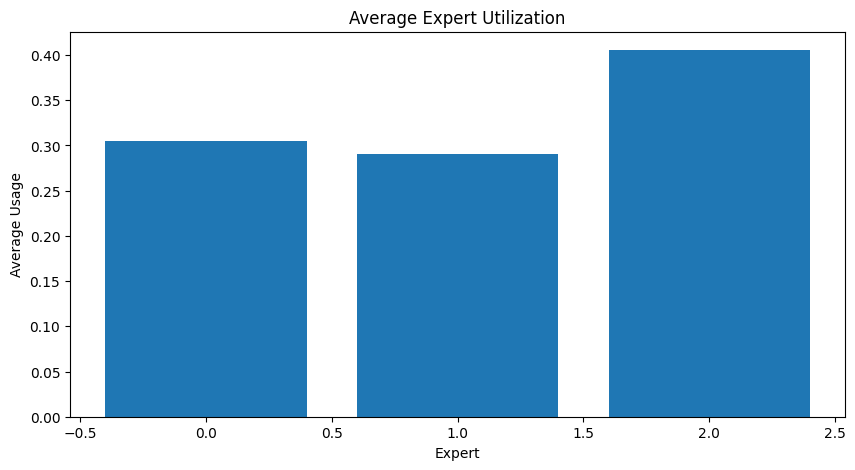

Training Gating Network:  12%|█▏        | 37/300 [00:06<00:40,  6.43it/s]

Epoch 35: Train Loss: 0.9615, Val Loss: 1.1135


Training Gating Network:  12%|█▏        | 37/300 [00:06<00:44,  5.96it/s]


Early stopping triggered


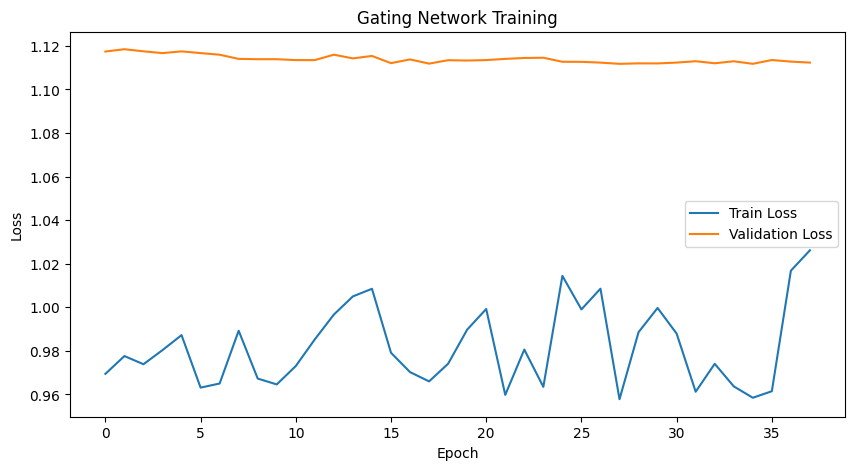

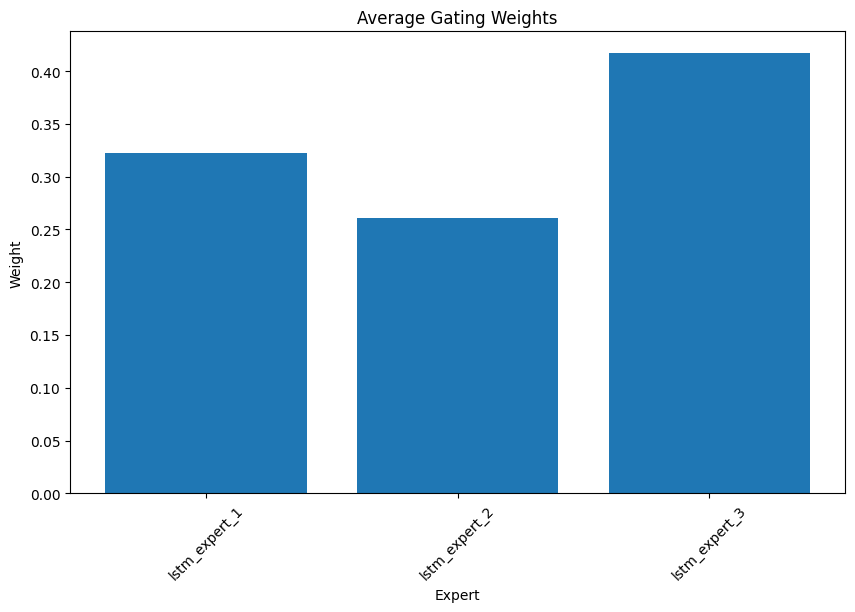

In [27]:
import torch.optim as optim
from torch.autograd import Variable

# expert_config = {
#     "lstm_expert_1": list(range(152)) + list(range(467,595)) ,
#     "lstm_expert_2": list(range(152)) + list(range(152,452)),
#     "lstm_expert_3": list(range(152)) + list(range(452,467)),
# }
expert_specs = {
    "lstm_expert_1": ["OneHotEmbedding", "MorganFingerPrintEmbedding"],
    "lstm_expert_2": ["OneHotEmbedding", "Mol2VecEmbedding"],
    "lstm_expert_3": ["OneHotEmbedding", "SMILESEmbedding"],
}

expert_config = preprocessor_train.generate_expert_config(expert_specs)

# print(expert_config)

output_size = 18211
epochs = 300
folds = 3

# model = MixtureOfExperts(expert_config, output_size)
# model.float()
# model.to(device)

# train_losses, val_losses = train_model(model, train_loader, val_loader, epochs)
# models, train_losses_cv, val_losses_cv = cross_validate_model(MixtureOfExperts, expert_config, X, y, folds, epochs)
moe = MixtureOfExperts(expert_config, output_size)
moe.to(device)

# Pretrain experts (if needed)
for expert_name, expert in moe.experts.items():
    print(f"Pretraining {expert_name}")
    feature_indices = expert_config[expert_name]
    train_losses, val_losses = pretrain_expert(expert, train_loader, val_loader, feature_indices, device, epochs=epochs)
    plot_training_curves(train_losses, val_losses, f"{expert_name} Pretraining")

# Train gating network with improvements
print("Training gating network")
train_losses, val_losses = train_gating_network(moe, train_loader, val_loader, device, epochs=300, lr=1e-4)
plot_training_curves(train_losses, val_losses, "Gating Network Training")

# Visualize final gating weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(moe.experts)), moe.last_gating_weights.cpu().mean(dim=0))
plt.title("Average Gating Weights")
plt.xlabel("Expert")
plt.ylabel("Weight")
plt.xticks(range(len(moe.experts)), list(moe.experts.keys()), rotation=45)
plt.show()

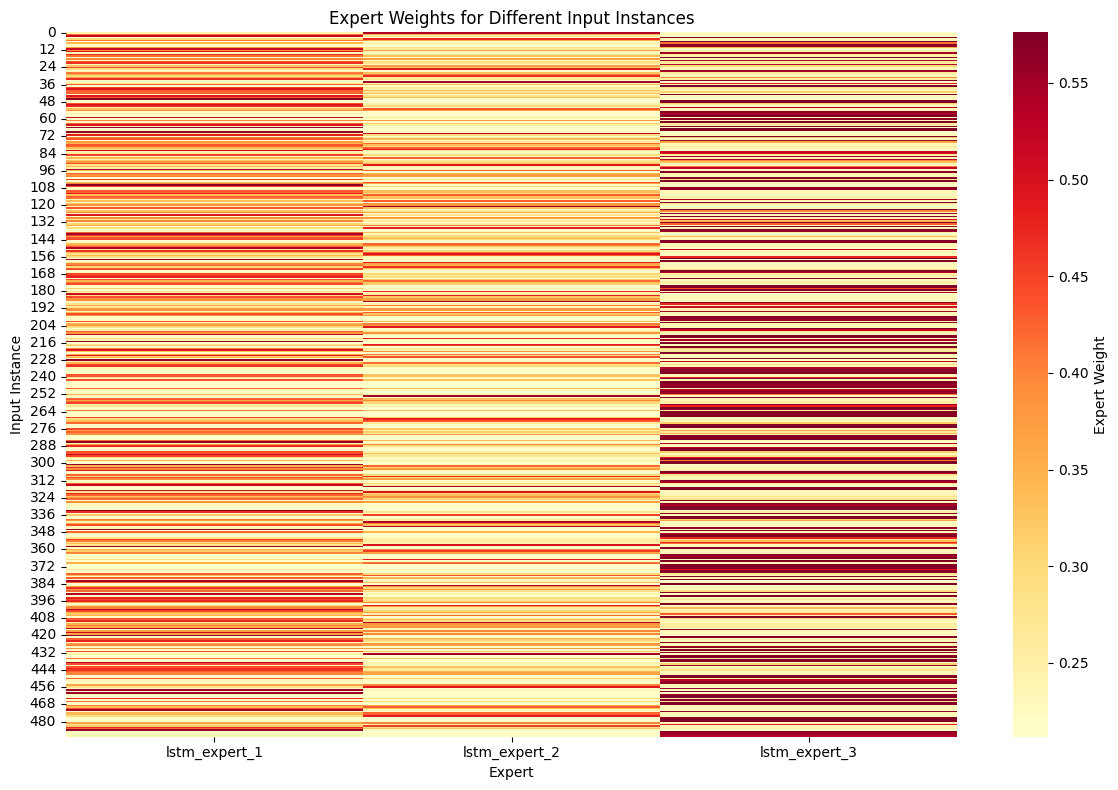

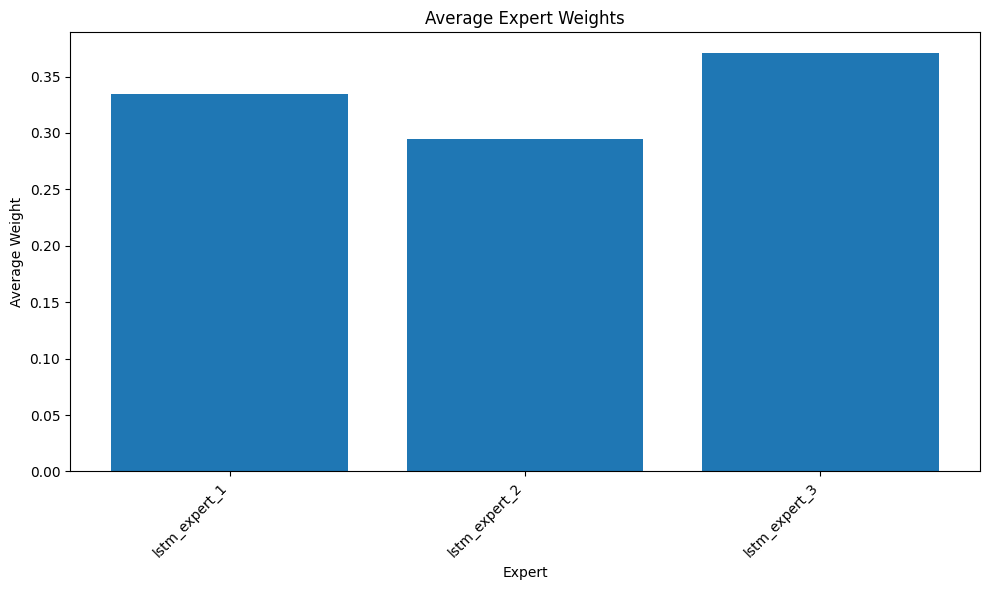

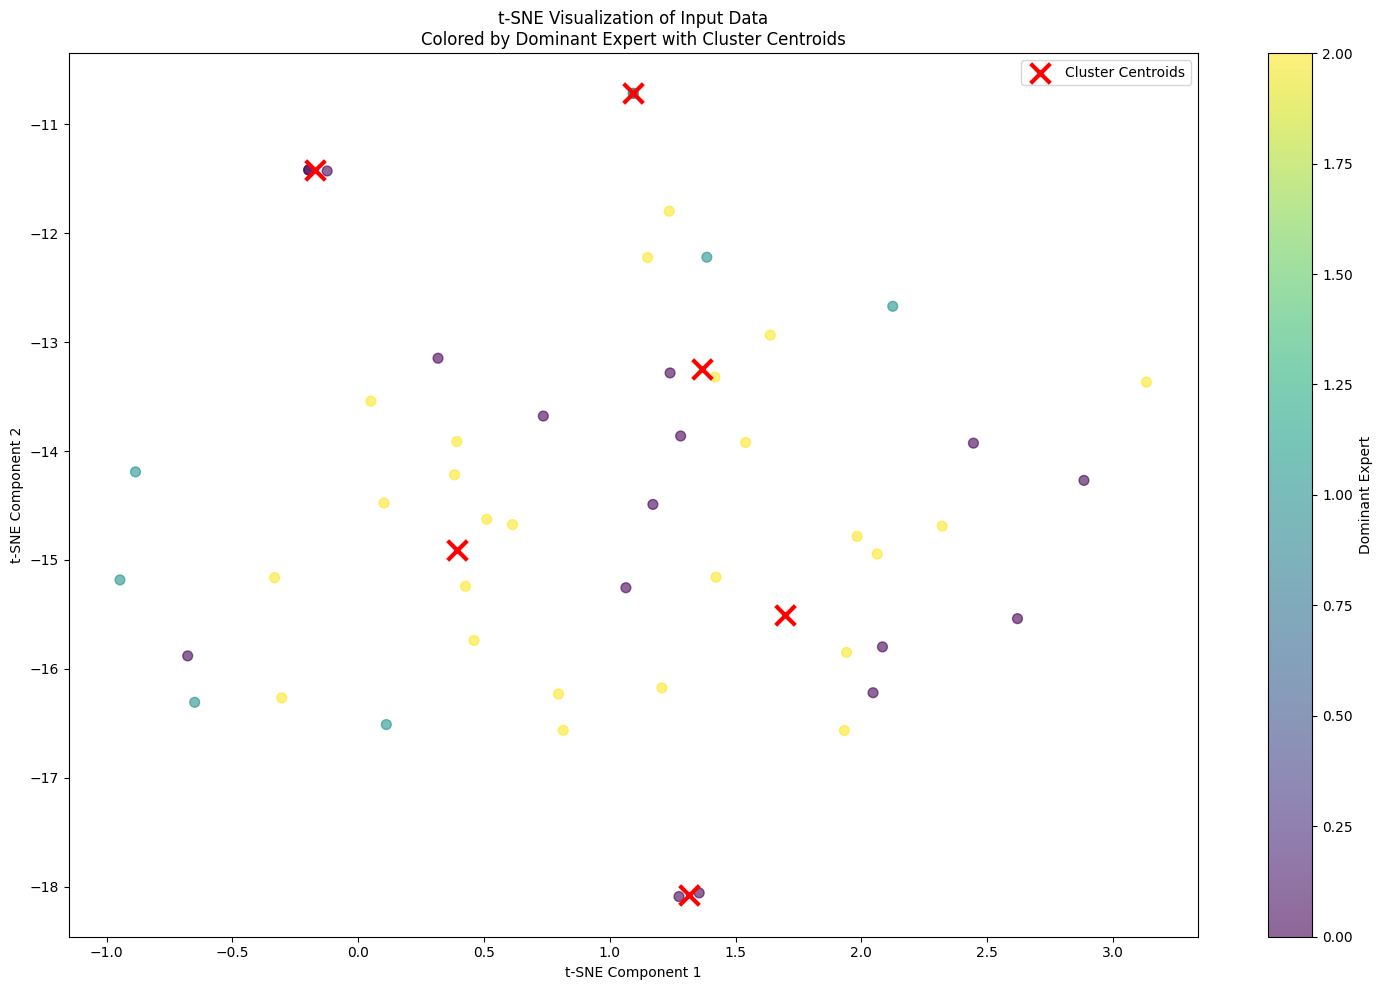

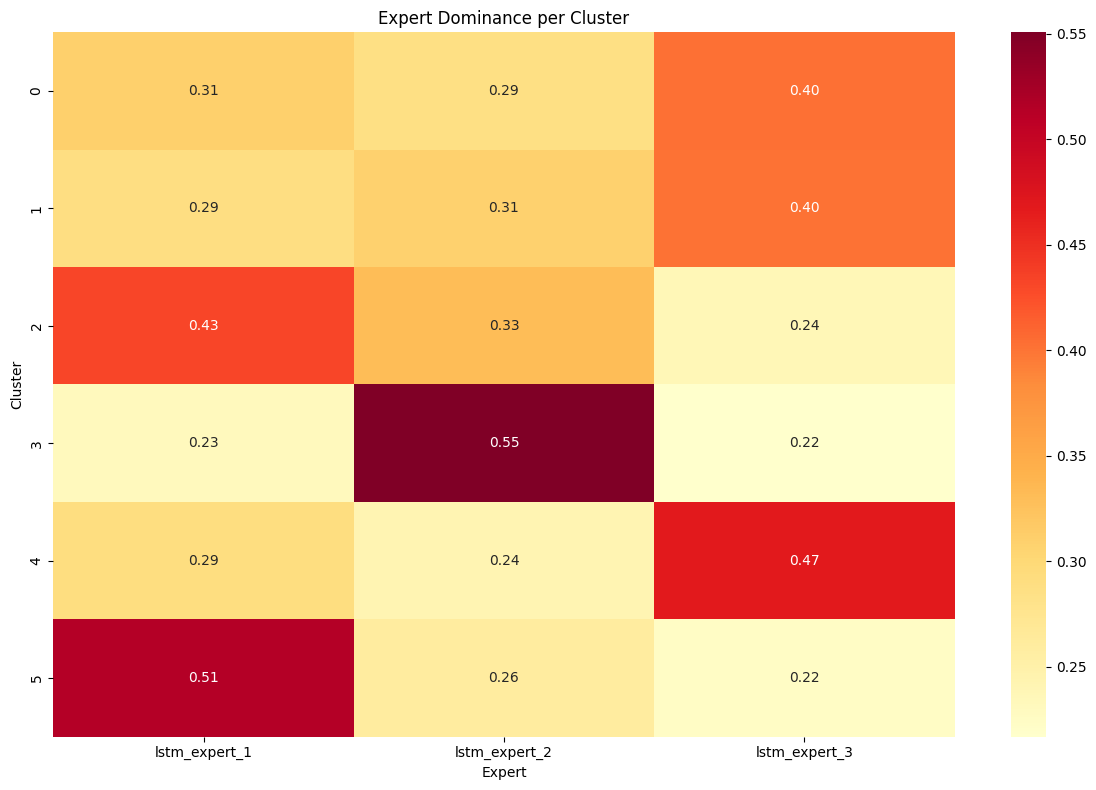

In [30]:
expert_names = list(expert_config.keys())
# model = models[-1]
model = moe
num_samples = 50
clusters = 6
# Call the function with the expert names


visualize_expert_weights(model, train_loader, expert_names, num_samples)
analyze_expert_clusters(model, train_loader, expert_names, num_samples, clusters)
# compute_feature_importance(model, X, feature_names, k=1)

In [ ]:
id_map = pd.read_csv(f"{data_path}/id_map.csv")
sm_name_to_smiles = df.set_index('sm_name')['SMILES'].to_dict()
len(sm_name_to_smiles)
id_map['SMILES'] = id_map['sm_name'].map(sm_name_to_smiles)
id_map.isna().sum()

In [ ]:
df_test = pd.DataFrame(id_map, columns=['cell_type', 'sm_name', 'SMILES'])
processed_df_test = preprocessor_train.preprocess(df_test, fit=False)
print("Processed Testing DataFrame shape:", processed_df_test.shape)
print("Testing Embedding indices:", preprocessor_train.embedding_indices)

In [ ]:
test_array =  processed_df_test.to_numpy()
model.to(device)
target_pred = model(torch.Tensor(test_array).to(device))

In [ ]:
res = target_pred.cpu()
sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
sample_columns = sample_submission.columns
sample_columns= sample_columns[1:]
submission_df = pd.DataFrame(res.detach().numpy(), columns=sample_columns)
submission_df.insert(0, 'id', range(255))
submission_df.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c open-problems-single-cell-perturbations -f "submission.csv" -m "ola_test"